In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

import os

import time
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning) # LogisticRegression() tends to complain with moderate number of iters.
warnings.filterwarnings("ignore", category=FutureWarning) # seaborn issues

In [2]:
#df = pd.read_excel(os.path.join(path, "ewp_final_excel_June_24_2024.xlsx"))
df = pd.read_csv("ewp_final_excel_2024_06_25.csv")

df_X = df.drop('SFTGcode', axis = 1)
df_X = df_X.iloc[:,3:-3] # exclude country, COW, year; and the three binary indicators at the far end.
df_Y = df[['coercive_control', 'id_target_gps', 'existential_threat']]


# Bootstraping for the same process with both classifiers. Collecting then flattening results will give variance bars.

# WARNING: code will take some time to run. We're using multiprocessing to parallelize; some reworking to make the unit of work into a function that doesn't immediately map onto the above workflow.

In [3]:
def bootstrap_iteration(inputs):
    #
    # outputs: for the given seed, a table of both logistic regression and random forest results and the 
    # matched results with random shuffling of labels, for all test set sizes, for a fixed coding.
    #
    # inputs: a list/tuple of the form:
    #     ( (bootstrap_iter, print_every, max_iter, df_copy), code)
    # why? idk. 
    #
    # bootstrap_iter: integer identifier of the call, 0 through num_bs-1 . Also used in part to seed the RNG.
    # print_every: integer, setting, used in a flag to determine whether a call prints when it's finished.
    # max_iter: integer, setting, used in a flag to determine whether a call prints when it's finished.
    # code: string, one of 'coercive_control', 'id_target_gps', 'existential_threat')
    #
    iter_tuple, code = inputs
    bs_iter, print_every, max_iter, df_X_copy, df_Y_copy = iter_tuple
    
    short_name = ''.join([s[0] for s in code.split('_')]) # abbreviate codes by first letter after underscore.
    _seed = ((bs_iter+1) * os.getpid() * int(time.time())) % 2718281828 # unique seed for the bootstrap

    
    np.random.seed(_seed)
    _Y = df_Y_copy[code]
    rows=[]

    _Y_shuffled = np.random.permutation(_Y)

    # All this could be done with a fancier loop/taking in a classifier function/instantiator as input.
    # But I don't want to refactor the functions at the beginning.
    
    _state = np.random.get_state()
    np.random.set_state(_state)

    ##########
    # set up the train/testing sets by train/test size in advance.
    splits = {k:train_test_split(df_X_copy, _Y, test_size = k/10, stratify=_Y) for k in range(1,10)} # test set decile (1 through 9 rather than 0.1 through 0.9) partitions.
    np.random.set_state(_state)
    splits_shuffle = {k:train_test_split(df_X_copy, _Y_shuffled, test_size = k/10, stratify=_Y_shuffled) for k in range(1,10)}
    #X_train, X_test, Y_train, Y_test = train_test_split(X, _Y, test_size = t, stratify=_Y)

    for k in range(1,10): # iterating over test set sizes up to 0.9
        # non-shuffled
        X_train, X_test, Y_train, Y_test = splits[k]
        
        model_lr = LogisticRegression(max_iter = 200)
        model_lr.fit(X_train, Y_train)
        y_pred_lr = model_lr.predict(X_test)
        acc_lr = accuracy_score(Y_test, y_pred_lr)
        f1_lr = f1_score(Y_test, y_pred_lr)
        
        model_rf = RandomForestClassifier()
        model_rf.fit(X_train,Y_train)
        y_pred_rf = model_rf.predict(X_test)
        acc_rf = accuracy_score(Y_test, y_pred_rf)
        f1_rf = f1_score(Y_test, y_pred_rf)
        
        # 
        # each row:
        # RNG seed, guidlines code, classifier, short classifier, test set size, accuracy, shuffled/not shuffled
        rows.append([_seed, bs_iter, code, 'Logistic Regression', 'LR', k/10, acc_lr, f1_lr, 'N'])
        rows.append([_seed, bs_iter, code, 'Random Forest', 'RF', k/10, acc_lr, f1_rf, 'N'])
        ##############

       # shuffled
        X_train, X_test, Y_train, Y_test = splits_shuffle[k]
        
        model_lr = LogisticRegression(max_iter = 200)
        model_lr.fit(X_train, Y_train)
        y_pred_lr = model_lr.predict(X_test)
        acc_lr = accuracy_score(Y_test, y_pred_lr)
        f1_lr = f1_score(Y_test, y_pred_lr)
        
        model_rf = RandomForestClassifier()
        model_rf.fit(X_train,Y_train)
        y_pred_rf = model_rf.predict(X_test)
        acc_rf = accuracy_score(Y_test, y_pred_rf)
        f1_rf = f1_score(Y_test, y_pred_rf)
        
        rows.append([_seed, bs_iter, code, 'Logistic Regression', 'LR', k/10, acc_lr, f1_lr, 'Y'])
        rows.append([_seed, bs_iter, code, 'Random Forest', 'RF', k/10, acc_lr, f1_rf, 'Y'])
        
            
    #########
    # compile and output.
    outputs = pd.DataFrame(rows, columns=['rng_seed', 'bootstrap_iter', 'code', 'classifier', 'clf', 'test_size', 'acc', 'f1', 'shuffled'])
    
    if ((bs_iter+1)%print_every)==0:
        print(f'Iter {bs_iter+1} of {max_iter} done.')
    
    return outputs

In [4]:
# Master function to submit parameter sweeps for this project. 
# Can also evaluate timing/efficacy of multiprocessing (process-level parallelism).
# Spoiler: it doesn't speed things up; numpy/scikit-learn seem to have native parallelism.
#
# Solution: on big machine, just hand off to a single process with many cores, or just do many sequestered single-core instances/calls.
# On the 6-core/12 with hyperthreading I seem to get one iteration done in about 10~12 seconds.

def test_timings(nbs=10, codes=['id_target_gps'], print_every=1, nproc=1):
    # nbs: number of bootstraps to pass to itertools (each call handles a single bootstrap sample).
    # codes: list of target variables to pass through to itertools.product(). if you want to use this for the whole shebang, 
    #     pass all three ['id_target_gps', 'coercive_control', 'existential_threat']
    # print_every: integer (default: 1)
    # nproc: integer number of processes for multiprocessing.Pool (reminder: does nothing to bump up b/c of 
    #     package-level parallelism). (default: 1)
    #
    # Outputs: dataframe of accuracies across all parameter choices; column names:
    #    [rng_seed, bootstrap_iter, code, classifier, clf, test_size, acc, shuffled]
    import multiprocessing
    import itertools
    import copy

    pool = multiprocessing.Pool(nproc) # number of asynchronous processes (parallelism).
    inputs = itertools.product(zip(range(nbs), nbs*(print_every,), nbs*(nbs,) ,nbs*[copy.deepcopy(df_X)], nbs*[copy.deepcopy(df_Y)]), codes)
    results = pool.map(bootstrap_iteration, inputs)
    results = pd.concat(results, axis=0, ignore_index=True)
    return results

#%time [bootstrap_iteration([(19,10,100,df),'coercive_control']) for _ in range(30)]
%time thing=test_timings(2)
thing.tail()

Iter 1 of 2 done.
Iter 2 of 2 done.
CPU times: user 9.73 ms, sys: 12.7 ms, total: 22.4 ms
Wall time: 3.83 s


,rng_seed,bootstrap_iter,code,classifier,clf,test_size,acc,f1,shuffled
67,2188033508,1,id_target_gps,Random Forest,RF,0.8,0.626866,0.093750,Y
68,2188033508,1,id_target_gps,Logistic Regression,LR,0.9,0.805310,0.639344,N
69,2188033508,1,id_target_gps,Random Forest,RF,0.9,0.805310,0.515464,N
70,2188033508,1,id_target_gps,Logistic Regression,LR,0.9,0.610619,0.241379,Y
71,2188033508,1,id_target_gps,Random Forest,RF,0.9,0.610619,0.222222,Y


In [5]:
if False:
    # uncomment to re-run; possibly replace demo results file.
    dfs_rf_bs = []
    dfs_lr_bs = []
    nbs = 10 # number of bootstrap samples
    print_every=1 # print an integer at iteration multiples of this.
    
    import multiprocessing
    import itertools
    import copy
    
    pool = multiprocessing.Pool(1) # number of asynchronous processes (parallelism).
    df_expt_mini = test_timings(nbs, codes=['id_target_gps', 'coercive_control', 'existential_threat'], print_every=5)
    df_expt_mini = pd.concat(df_expt_mini, axis=0, ignore_index=True)
    #df_expt_mini.to_csv('ebg_ewp_expt_9feb2026_mini.csv', index=None)


In [6]:
try:
    df_expt_mini = pd.read_csv('epg_ewp_expt_9feb2026_mini.csv')
except:
    print("uh oh -- check file paths or run the commented code above or ignore this cell if you have a different file.")

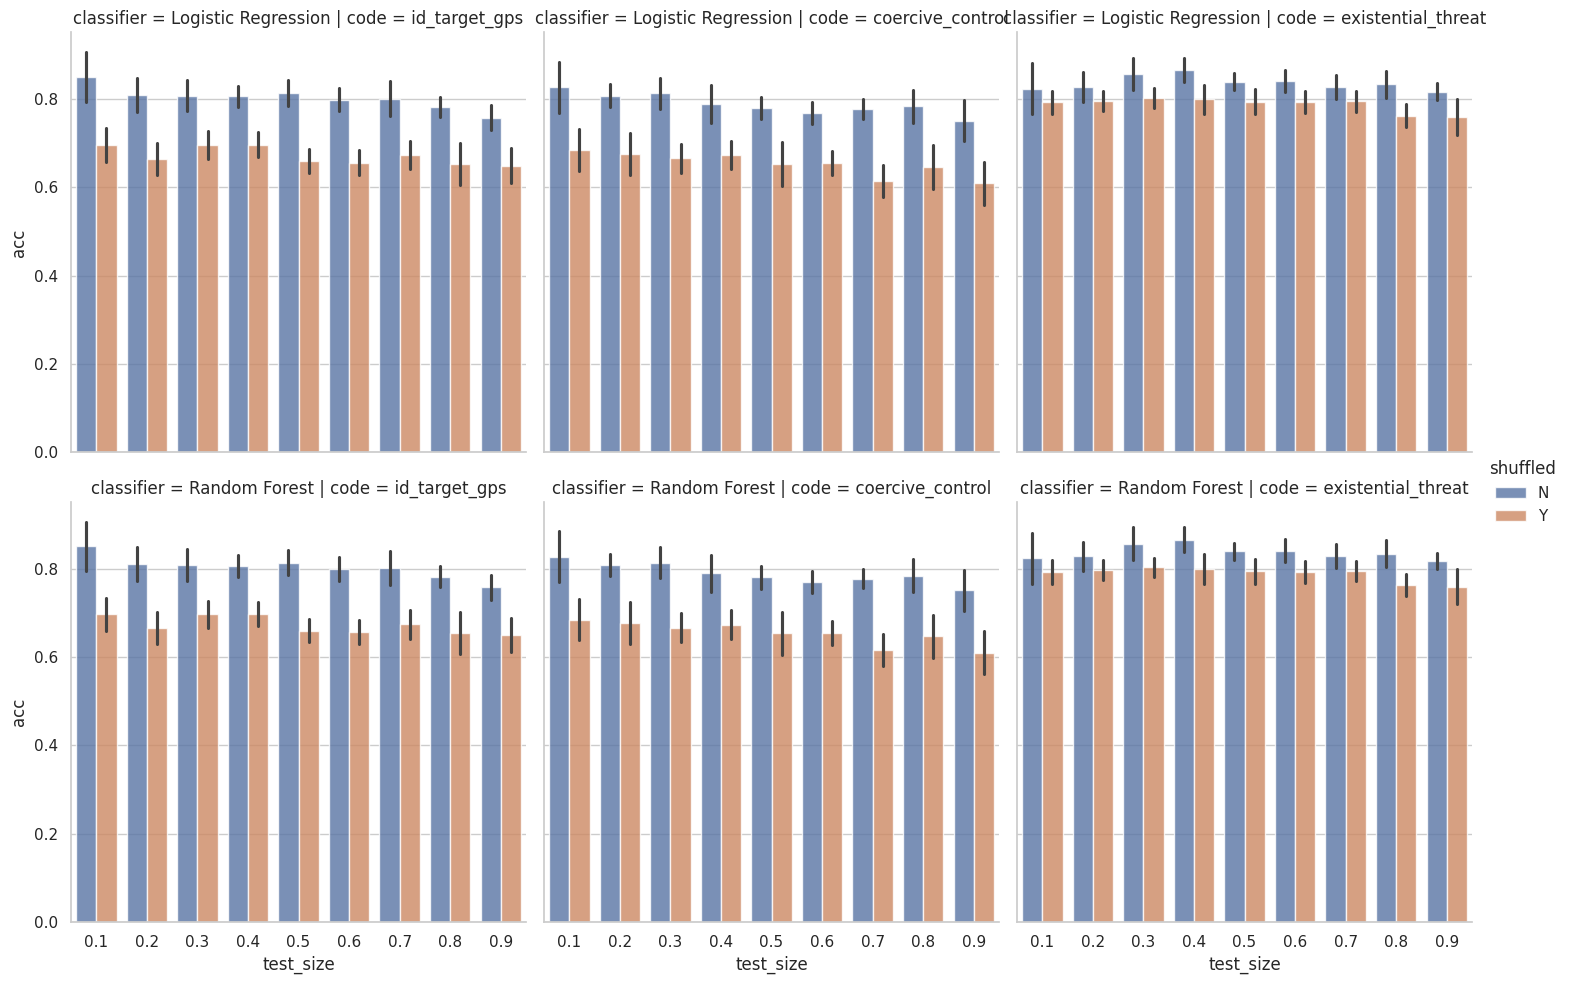

In [7]:
import seaborn as sns
sns.set_theme(style='whitegrid')

#df_results_rf_long = pd.melt(df_perm_results_rf, id_vars=['test_size'], value_name='acc', var_name='experiment')
#df_results_rf_long['shuffled'] = df_results_rf_long['experiment'].str.contains('shuffle')
#df_results_rf_long['guideline'] = df_results_rf_long['experiment'].str.split('_').map(lambda z: z[1]) # extract guideline from string
#df_results_rf_long['classifier'] = ['RandomForest']*(df_results_rf_long.shape[0])

g = sns.catplot(data=df_expt_mini, 
                kind='bar', col='code', row='classifier',
                x='test_size', y='acc', hue='shuffled', errorbar='sd', alpha=0.8
               )